# Wine Classification

In [4]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
# Change to top directory of your Drive
import os
os.chdir('/content/gdrive/Shared drives/AI4ALL SFU NLP GROUP 3/WINE')

In [7]:
# Load data
df = pd.read_csv('winemag-data-130k-v2.csv')

In [8]:
df.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [9]:
# Get only the columns we want
wine_df = df[['description', 'variety']].copy()

In [10]:
wine_df

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,Riesling
129967,Citation is given as much as a decade of bottl...,Pinot Noir
129968,Well-drained gravel soil gives this wine its c...,Gewürztraminer
129969,"A dry style of Pinot Gris, this is crisp with ...",Pinot Gris


In [11]:
wine_df['variety'].value_counts()[:5]

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Name: variety, dtype: int64

In [12]:
topVarieties = wine_df['variety'].value_counts()[:5].index.tolist()

In [13]:
wine_df_short = wine_df[wine_df.variety.isin(topVarieties)].copy()

In [14]:
wine_df_short

,description,variety
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay
20,Ripe aromas of dark berries mingle with ample ...,Red Blend
...,...,...
129956,"The blend is 44% Merlot, 33% Cabernet Sauvigno...",Bordeaux-style Red Blend
129958,This blend of Cabernet Sauvignon-Merlot and Ca...,Bordeaux-style Red Blend
129960,"Fresh and fruity, this is full of red cherry f...",Pinot Noir
129963,"A bouquet of black cherry, tart cranberry and ...",Cabernet Sauvignon


In [15]:
wine_df_short['variety_num'] = wine_df_short['variety'].astype('category').cat.codes

In [16]:
wine_df_short

,description,variety,variety_num
4,"Much like the regular bottling from 2012, this...",Pinot Noir,3
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon,1
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon,1
14,Building on 150 years and six generations of w...,Chardonnay,2
20,Ripe aromas of dark berries mingle with ample ...,Red Blend,4
...,...,...,...
129956,"The blend is 44% Merlot, 33% Cabernet Sauvigno...",Bordeaux-style Red Blend,0
129958,This blend of Cabernet Sauvignon-Merlot and Ca...,Bordeaux-style Red Blend,0
129960,"Fresh and fruity, this is full of red cherry f...",Pinot Noir,3
129963,"A bouquet of black cherry, tart cranberry and ...",Cabernet Sauvignon,1


In [17]:
# Split our data into training and test sets (80/20)
train_df, test_df = train_test_split(wine_df_short, test_size=0.2)

In [18]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = stopwords.words('english')
for i in topVarieties:
  stops.extend(i.lower().split(' '))
print(stops[-15:])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
["weren't", 'won', "won't", 'wouldn', "wouldn't", 'pinot', 'noir', 'chardonnay', 'cabernet', 'sauvignon', 'red', 'blend', 'bordeaux-style', 'red', 'blend']


In [19]:
def cleanText(text):
    # Remove new lines from the text
    text = text.replace("\n", " ")
    text = text.lower()
    text = text.split(' ')
    text = [w for w in text if not w in stops] 
    text = ' '.join(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [20]:
train_df['description'] = train_df['description'].apply(lambda x : cleanText(x))
test_df['description'] = test_df['description'].apply(lambda x : cleanText(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
train_df

,description,variety,variety_num
70904,shows ripe fruit bright acidity famous vineyar...,Pinot Noir,3
51848,made sauvignon merlot alicante sangiovese ...,Red Blend,4
118903,offbeat white varieties simple fruity tart win...,Red Blend,4
107898,wine seems ripe fruit rich opulent weight jam...,Bordeaux-style Red Blend,0
71850,– barrel sample wine dark extracted tannins de...,Bordeaux-style Red Blend,0
...,...,...,...
27668,intended commemorative wine celebrate estates ...,Red Blend,4
85188,succulent cherry cassis wine surprising level ...,Cabernet Sauvignon,1
125724,ripe blackberry cassis graphite pencil wood ar...,Red Blend,4
123285,taut young laced accents bitter greens fruit p...,Pinot Noir,3


In [22]:
X_train = train_df['description']
y_train = train_df['variety_num']
X_test = test_df['description']
y_test = test_df['variety_num']

In [23]:
vocab_size = 20000
max_seq_length = 400

In [24]:
# TfidfVectorizer converts text to a matrix of TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()

In [25]:
''' 
TO DO: Define our X and y from the training set
(Re)load the (cleaned) training and test datasets as X_train, y_train, X_test, y_test
'''
# TO DO: Load our pre-processed data into a dataframe
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

' \nTO DO: Define our X and y from the training set\n(Re)load the (cleaned) training and test datasets as X_train, y_train, X_test, y_test\n'

In [26]:
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

In [27]:
# Import classifiers from Scikit-learn
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [28]:
'''
TO DO: Define a list of models that we will be comparing. Choose from the ones
that were imported from above.
'''
NB = MultinomialNB()
SVC = LinearSVC()
RFC = RandomForestClassifier(max_depth=10)
models = [NB, SVC, RFC]

In [29]:
# Create a dictionary for storing the results of each run for each model
results = {}

# For each model, create a dictionary within results that stores the accuracy,
# f1 score and confusion matrix values
for model in models:
    results[model.__class__.__name__] = {'accuracy': [], 
                                       'f1_score': [], 
                                       'confusion_matrix': []}

In [30]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [31]:
for model in models:
    '''
    TO DO: For each model in our models list, we want to:

    1. Fit the model on X_train_vect and y_train

    2. Generate y_pred by calling model.predict
    '''
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    '''
    TO DO: Compute the following so we can add it to our results:
    acc - accuracy score
    f1  - f1 score
    cm - confusion matrix
    '''
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    print("done")
    results[model.__class__.__name__]['accuracy'] = acc
    results[model.__class__.__name__]['f1_score'] = f1
    results[model.__class__.__name__]['confusion_matrix'] = cm

done
done
done


{'accuracy': 0.789614773629865, 'f1_score': 0.7875431204019816, 'confusion_matrix': array([[ 845,  203,   16,  126,  142],
       [  14, 1264,    5,  475,  186],
       [  15,    7, 2267,   67,    4],
       [ 202,   80,   67, 2277,   21],
       [  41,  249,    8,  191, 1300]])}


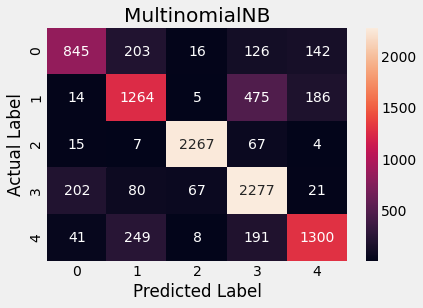

{'accuracy': 0.8548451151707704, 'f1_score': 0.8545705103743204, 'confusion_matrix': array([[1096,  104,   11,   67,   54],
       [  70, 1518,   10,  211,  135],
       [   6,   13, 2306,   30,    5],
       [ 124,  136,   54, 2287,   46],
       [  88,  187,   10,  101, 1403]])}


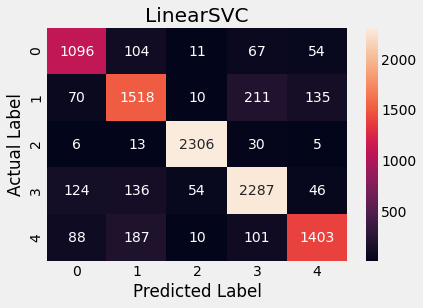

{'accuracy': 0.6147736298649722, 'f1_score': 0.5806315486330961, 'confusion_matrix': array([[ 187,   69,   16,  957,  103],
       [   2,  505,   12, 1373,   52],
       [   0,    0, 2207,  153,    0],
       [  14,    6,   62, 2563,    2],
       [   5,   95,   21,  938,  730]])}


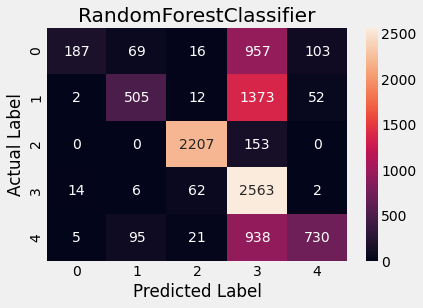

In [34]:
'''
TO DO: Display the results by printing out the accuracy, F1 score and confusion
matrix for each of the models.
'''
for model in results:
  print(results[model])
  cm = results[model]['confusion_matrix']
  fig = sns.heatmap(cm, annot=True, fmt="d")
  plt.title(model)
  plt.xlabel("Predicted Label")
  plt.ylabel("Actual Label")
  plt.show(fig)

In [47]:
model = tf.keras.models.load_model('wine_cnn_5_wines.h5')

In [40]:
# loading
with open('wine_tokenizer.pkl', 'rb') as handle:
    X_tokenizer = pickle.load(handle)

In [42]:
wineNames = {0: 'Bordeaux-style Red Blend',
 1: 'Cabernet Sauvignon',
 2: 'Chardonnay',
 3: 'Pinot Noir',
 4: 'Red Blend'}

In [54]:
wineReview = input("Enter a description of what you want your wine to taste like: ")
while(wineReview != 'exit'):
  wineReview = cleanText(wineReview)
  wine_tokenized = X_tokenizer.texts_to_sequences([wineReview])
  wine_padded = sequence.pad_sequences(wine_tokenized[0:1], maxlen=max_seq_length)
  predictedWine = np.argmax(model.predict(wine_padded), axis=-1)
  print("Neural Network: " + wineNames[int(predictedWine)])
  wineVect = vect.transform([wineReview])
  for modelA in models:
    print(str(modelA.__class__.__name__) + ": " + wineNames[int(modelA.predict(wineVect))])
  wineReview = input("Enter a description of what you want your wine to taste like: ")

Enter a description of what you want your wine to taste like: grapes
Neural Network: Red Blend
MultinomialNB: Red Blend
LinearSVC: Red Blend
RandomForestClassifier: Pinot Noir
Enter a description of what you want your wine to taste like: pineapple
Neural Network: Chardonnay
MultinomialNB: Chardonnay
LinearSVC: Chardonnay
RandomForestClassifier: Chardonnay
Enter a description of what you want your wine to taste like: spicy apples
Neural Network: Chardonnay
MultinomialNB: Chardonnay
LinearSVC: Chardonnay
RandomForestClassifier: Chardonnay
Enter a description of what you want your wine to taste like: deep thick
Neural Network: Chardonnay
MultinomialNB: Cabernet Sauvignon
LinearSVC: Chardonnay
RandomForestClassifier: Pinot Noir
Enter a description of what you want your wine to taste like: exit
